In [51]:
import json
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [40]:
requirements_with_package_version = None
with open("requirements_with_package_version.json", "r") as json_file:
    requirements_with_package_version = json.load(json_file)
remove_version = lambda s : s[:s.rfind('-')] if s.find("{") < 0 else None #remove noise
requirements_with_out_package_version = {k : [remove_version(s) for s in v if remove_version(s) != None] for k, v in requirements_with_package_version.items()}

requirements_pip_compiled = pd.read_csv('requirements.csv').drop_duplicates(subset="id", keep="first") #remove duplicate files
requirements_pip_compiled = requirements_pip_compiled[["id", "compiled"]].dropna()

In [41]:
requirements_pip_compiled_with_version, requirements_pip_compiled_without_version = {}, {}

for row in requirements_pip_compiled.iloc:
    lines_with_package = list(filter(lambda x: "==" in x, row["compiled"].split("\n")))

    requirements_pip_compiled_with_version[row["id"]] = \
        list(map(lambda x: x.replace("==", "-"), lines_with_package))
    
    requirements_pip_compiled_without_version[row["id"]] = \
        list(map(lambda x: x[:x.index("==")], lines_with_package))

In [42]:
with open("requirements_pip_compiled_with_version.json", "w") as json_file:
    json.dump(requirements_pip_compiled_with_version, json_file)

In [43]:
requirements_with_out_package_version
columns = {}
next_ind = 0
for v in requirements_with_out_package_version.values():
    for package in v:
        if package not in columns:
            columns[package] = next_ind
            next_ind += 1

matrix_array = np.zeros((len(requirements_with_out_package_version), len(columns)))

for i, (_, v) in enumerate(requirements_with_out_package_version.items()):
    for package in v:
        matrix_array[i][columns[package]] = 1


matrix_df = pd.DataFrame(matrix_array, columns=columns.keys())


pip_compiled_columns = {}
next_ind = 0
for v in requirements_pip_compiled_without_version.values():
    for package in v:
        if package not in columns:
            pip_compiled_columns[package] = next_ind
            next_ind += 1


In [44]:
import re
def parse_req(r):
	skip_prefix = set(['====', '--', '~~~'])
	lines = r.split("\n")
	
	def remove(char, lines):
		return map(lambda x: x[:x.find(char)] if x.find(char) > -1 else x, lines)

	lines = remove("#", lines) #remove comments
	lines = remove("\\", lines)
	lines = remove("--hash", lines)
	lines = list(map(str.strip, lines))


	output = []
	for l in lines:
		skip = False
		for s in skip_prefix:
			if s in l:
				skip = True
		if l == '':
			skip = True
		elif l[0] == '*':
			skip = True

		if not skip:
			a = re.split('(==|!=|>=|<=|<|>|~=|===|;|@)', l)
			a = [item.strip() for item in a]
			if len(a) == 1 and a[0].find(' ') == -1:
				output.append(a)
			elif len(l) >1:
				output.append(a)
			else:
				pass
				#print(l)
		elif l!='' and l!='\n':
			pass
			#print(l)

	return output

In [45]:
df = pd.read_csv('requirements.csv')
df_unique = df[~df['id'].duplicated()] #some files are duplicated

requirements_raw = {}  #key: id,  value: list of packages
COLNUM = 'raw' #'compiled' 
for r in df[['id', COLNUM]].values:
    if pd.isna(r[1]):
        continue
    requirements_raw[r[0]] = parse_req(r[1])

packages_raw = {} #key: package name, value: count
for f in requirements_raw.values():
    for line in f:
        try:
            if line[0] not in packages_raw:
                packages_raw[line[0]] = 0
            packages_raw[line[0]] += 1
        except IndexError:
            print(line)   

In [46]:
from packaging import version

packages_operator = {}
package_explicit_versions = {}
operator_count = {"Explicit (latest)":0, "Explicit (others)":0, 'Range':0, 'Implicit':0, 'Total': 0}
range_ops = set(["!=", ">=", "<=", "<", ">", "~="])
for req in requirements_raw.values():
    for p in req:
        if p[0] not in package_explicit_versions:
            package_explicit_versions[p[0]] = version.Version("0.0.0")
        if len(p) > 1 and p[1] == "==":
            try:
                v = version.Version(p[2])
                if package_explicit_versions[p[0]] < v:
                    package_explicit_versions[p[0]] = v
            except:
                pass


for req in requirements_raw.values():
    for p in req:
        if p[0] not in packages_operator:
            packages_operator[p[0]] = operator_count.copy()
        packages_operator[p[0]]['Total']+=1
        
        if len(p) == 1:
            packages_operator[p[0]]['Implicit']+=1
        elif p[1] == "==" or p[1] == "===":
            try:
                v = version.Version(p[2])
                if package_explicit_versions[p[0]] == v:
                    packages_operator[p[0]]["Explicit (latest)"]+=1
                else:
                    packages_operator[p[0]]["Explicit (others)"]+=1
            except:
                pass
        else:
            for s in p:
                if s in range_ops:
                    packages_operator[p[0]]["Range"]+=1
                    break

for k, v in packages_operator.items():
    for kk, vv in v.items():
        if kk != 'Total':
            packages_operator[k][kk] /= packages_operator[k]['Total']

df_packages_operator = pd.DataFrame.from_dict(packages_operator, orient='index').sort_values("Total", ascending=False)

total_row = df_packages_operator.sum().to_frame().transpose().drop("Total", axis=1)
total_row = total_row / total_row.sum(axis=1).iloc[0]
total_row.index = ["Average"]

In [47]:
df_packages_operator.rename(index={'python-dateutil':'dateutil'},inplace=True)

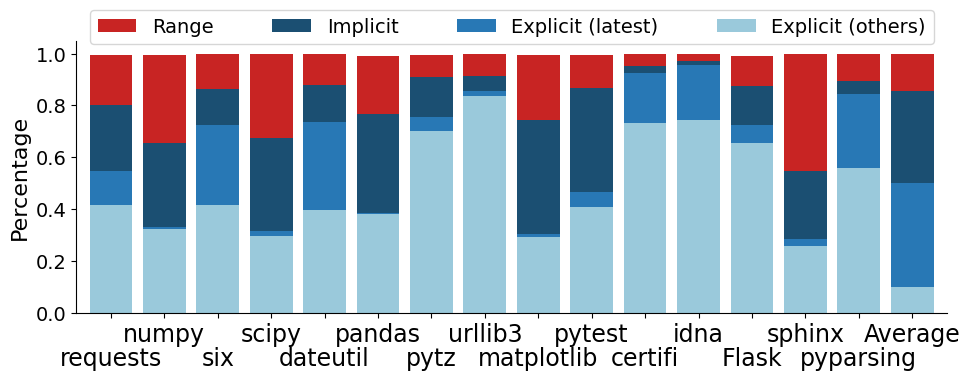

In [48]:
#versions:
#  implicit : version not specified
#  explicit (latest) : latest versions specified (==)
#  explicit (others) : old versions specified (==)
#  range: (>, <, <=, >=, !=, ~=)

NUM = 15
bar_width = 0.8
title_size, label_size, tick_size, legend_size = 17, 16, [17, 14], 14
colors = ['#9AC9DB', '#2878B5', '#1B4F72', '#C82423']

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
df_plot = pd.concat([df_packages_operator[['Explicit (others)', 'Explicit (latest)', 'Implicit', 'Range']].head(NUM), 
                     total_row[['Range', 'Explicit (others)', 'Explicit (latest)', 'Implicit']]])
df_plot.plot.bar(ax=ax, stacked=True, width=bar_width, color=colors)

#fig.suptitle('Package Version (Explicit vs Implicit)')#, fontsize=title_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', rotation=0, labelsize=tick_size[0])
ax.tick_params(axis='y', labelsize=tick_size[1])
# for tick in ax.get_xticklabels():
#     tick.set_horizontalalignment('right')

ax.set_ylabel("Percentage", fontsize=label_size)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), fontsize=legend_size,
    loc="upper right", ncol=len(df_plot.columns), bbox_to_anchor=(0.996,1.15), columnspacing=3.01)

text_labels = ax.get_xticklabels()
for i in range(0, NUM, 2):
    position = text_labels[i].get_position()
    text_labels[i].set_position((position[0],position[1]-0.09))
ax.set_xticklabels(text_labels)

# for bar, stat in zip(ax.get_children()[15::16], df_plot.loc["Average"]):
#     position = bar.get_center()
#     #print(position)
#     ax.text(position[0],position[1], f'{stat:.2f}', horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.savefig("version-specification.pdf", format="pdf", bbox_inches="tight")

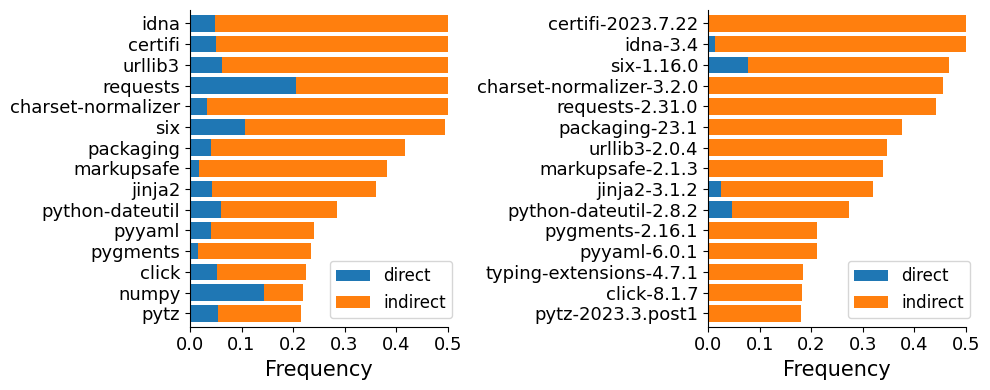

In [13]:
#direct vs indirect
NUM = 15
bar_width = 0.8
title_size, label_size, tick_size, legend_size = 17, 15, [13, 13], 12


combined_df = [None, None]
for i, (require, complete) in enumerate([(requirements_with_out_package_version, requirements_pip_compiled_without_version), (requirements_with_package_version, requirements_pip_compiled_with_version)]):
    num_files = len(complete)
    package_count = pd.DataFrame([x for k, v in require.items() \
        for x in v if k in complete])[0].value_counts() / num_files
    compiled_count = pd.DataFrame([x for v in complete.values() for x in v])[0].value_counts() / num_files 

    combined_df[i] = pd.DataFrame({"direct":package_count, "indirect":compiled_count}).fillna(0).sort_values("indirect", ascending=False)
    combined_df[i]["indirect"] = combined_df[i]["indirect"] - combined_df[i]["direct"]
# Popularity
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

#fig.suptitle(f'Package Popularity', fontsize=17)
for i in range(2):
    combined_df[i].head(NUM).plot.barh(ax=axs[i], width=bar_width, stacked=True)

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
    axs[i].tick_params(axis='x', labelsize=tick_size[0])
    axs[i].tick_params(axis='y', labelsize=tick_size[1])
    
    axs[i].set_xlabel("Frequency", fontsize=label_size)
    axs[i].set_ylabel("")
    
    axs[i].invert_yaxis()
    axs[i].set_xticks([x/10 for x in range(0, 6)])
    axs[i].set_xlim(0, 0.5)
    
    axs[i].legend(fontsize=legend_size, loc="lower right", bbox_to_anchor=(1.05,0))

plt.tight_layout()
plt.savefig("stacked-popularity.pdf", format="pdf", bbox_inches="tight")

In [14]:
def invert_map(input_map):
    output_map = {}
    for k, v in input_map.items():
        for x in v:
            if x not in output_map:
                output_map[x] = []
            
            output_map[x].append(k)
            
    return output_map

inv_requirements_with_out_package_version = invert_map(requirements_with_out_package_version)
inv_requirements_with_package_version = invert_map(requirements_with_package_version)
inv_requirements_pip_compiled_without_version = invert_map(requirements_pip_compiled_without_version)
inv_requirements_pip_compiled_with_version = invert_map(requirements_pip_compiled_with_version)

In [15]:
def calculate_coverage_N(N, file_map, inv_map):
    package_count = pd.DataFrame([x for v in file_map.values() for x in v])[0].value_counts()
    top_packages = package_count.head(N)
    top_packages_file = {file_id for pkg in top_packages.index for file_id in inv_map[pkg]}
    return len(top_packages_file)/len(file_map)

#requirements.txt
NUM = 15
print("requirements.txt")
#non-versioned
x = calculate_coverage_N(NUM, requirements_with_out_package_version, inv_requirements_with_out_package_version)
print(f"  non-versioned: {x}")
#versioned
x = calculate_coverage_N(NUM, requirements_with_package_version, inv_requirements_with_package_version)
print(f"  versioned: {x}")
#complete.txt
print("complete.txt")
#non-versioned
x = calculate_coverage_N(NUM, requirements_pip_compiled_without_version, inv_requirements_pip_compiled_without_version)
print(f"  non-versioned: {x}")
#versioned
x = calculate_coverage_N(NUM, requirements_pip_compiled_with_version, inv_requirements_pip_compiled_with_version)
print(f"  versioned: {x}")

requirements.txt
  non-versioned: 0.6215127092374457
  versioned: 0.45536267823930565
complete.txt
  non-versioned: 0.8816446402349486
  versioned: 0.8237885462555066


In [16]:
def calculate_coverage(file_map, inv_map):
    package_count = pd.DataFrame([x for v in file_map.values() for x in v])[0].value_counts()
    package_coverage = {"index":[], "coverage":[]}
    
    for i in range(1, len(package_count)):
        top_packages = package_count.head(i)
        top_packages_file = {file_id for pkg in top_packages.index for file_id in inv_map[pkg]}
        package_coverage["index"].append(i)
        package_coverage["coverage"].append(len(top_packages_file)/len(file_map))
        
    return pd.DataFrame(package_coverage["coverage"], index=package_coverage["index"])

package_coverage, version_coverage=[None,None], [None,None]

package_coverage[0] = calculate_coverage(requirements_with_out_package_version, inv_requirements_with_out_package_version)
version_coverage[0] = calculate_coverage(requirements_with_package_version, inv_requirements_with_package_version)

package_coverage[1] = calculate_coverage(requirements_pip_compiled_without_version, inv_requirements_pip_compiled_without_version)
version_coverage[1] = calculate_coverage(requirements_pip_compiled_with_version, inv_requirements_pip_compiled_with_version)

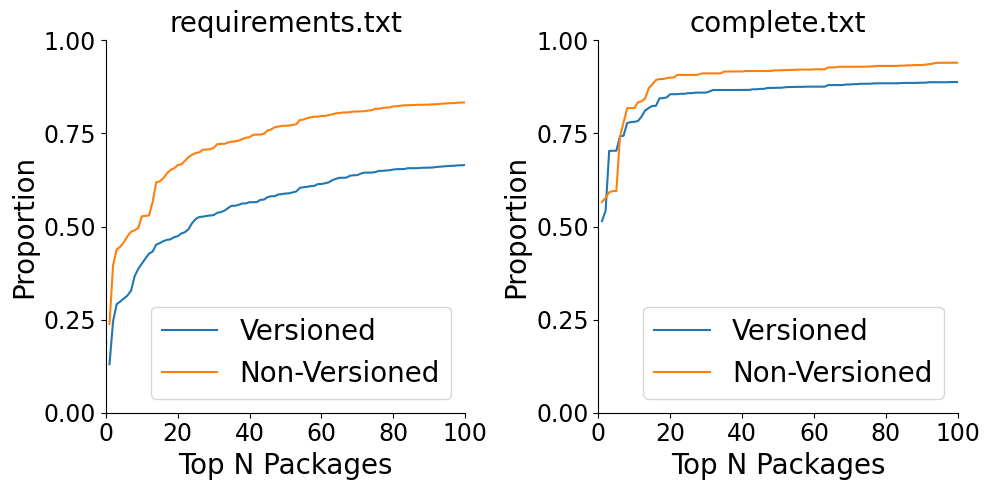

In [62]:
#cumulative coverage
title_size, label_size, legend_size, tick_size,  xlim = 20, 20, 20, (17, 17), (0, 100)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in (0, 1):
    version_coverage[i].rename(columns={0:"Versioned"}).plot(ax=axs[i])
    package_coverage[i].rename(columns={0:"Non-Versioned"}).plot(ax=axs[i])
    
    #axs[i].plot(xlim, [0.5, 0.5], linestyle='--')
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
    axs[i].tick_params(axis='x', labelsize=tick_size[0])
    axs[i].tick_params(axis='y', labelsize=tick_size[1])
    axs[i].set_yticks([x/100 for x in range(0, 101, 25)])
    
    axs[i].set_xlabel("Top N Packages", fontsize=label_size)
    axs[i].set_ylabel("Proportion", fontsize=label_size)
    
    axs[i].legend(loc="lower right", fontsize=legend_size)
    
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(0, 1)

    
axs[0].set_title("requirements.txt", fontsize=title_size)
axs[1].set_title("complete.txt", fontsize=title_size)

    
plt.tight_layout()
plt.savefig("cumulative-coverage.pdf", format="pdf", bbox_inches="tight")

In [57]:
#section 2.1

#Figure 2 shows how versions are specified for the 15 most
#popular packages, as well as an average over all XXX pack-
#ages in our dataset.

pkg_list = { pkg for v in requirements_with_out_package_version.values() for pkg in v if pkg != ''}
len(pkg_list)

11842

In [58]:
package_count, stats = {}, {}

package_count["raw"] = pd.DataFrame({k: len(v) for k, v in requirements_with_out_package_version.items()}\
    .items(), columns=['id', 'package_count']).set_index('id').sort_values("package_count")
stats["raw"] = [package_count["raw"]['package_count'].mean(), 
                package_count["raw"]['package_count'].median(), 
                package_count["raw"]['package_count'].mode()[0]]

package_count["compiled"] = pd.DataFrame({k: len(v) for k, v in requirements_pip_compiled_without_version.items()}\
    .items(), columns=['id', 'package_count']).set_index('id').sort_values("package_count")
stats["compiled"] = [package_count["compiled"]['package_count'].mean(), 
                     package_count["compiled"]['package_count'].median(), 
                     package_count["compiled"]['package_count'].mode()[0]]

package_count["filtered"] = pd.DataFrame({k: len(v) for k, v in requirements_with_out_package_version.items() \
    if k in requirements_pip_compiled_without_version}.items(), columns=['id', 'package_count'])\
        .set_index('id').sort_values("package_count")
stats["filtered"] = [package_count["filtered"]['package_count'].mean(), 
                     package_count["filtered"]['package_count'].median(), 
                     package_count["filtered"]['package_count'].mode()[0]]

116.0


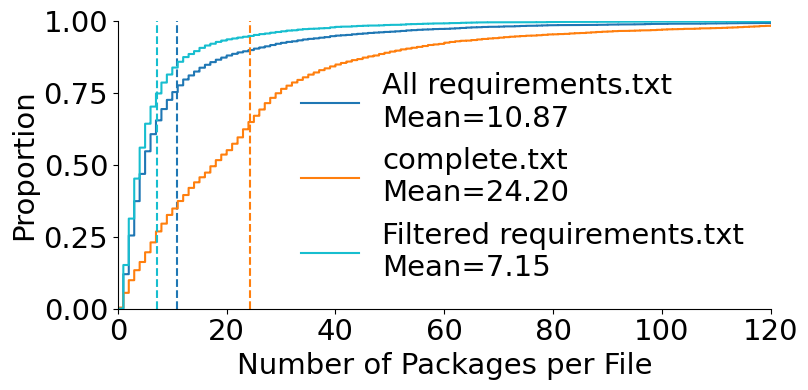

In [79]:
colors = ["#EB9A66", "#7BCCC4", "#A63539"]
title_size, label_size, legend_size, tick_size,  xlim = 21, 21, 21, (21, 21), (0, 120)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
colors=["C0", "C1", "C9"]

handles = []
labels = ["All requirements.txt\nMean=%.2f", "complete.txt\nMean=%.2f", "Filtered requirements.txt\nMean=%.2f"]
for i, key in enumerate(package_count.keys()):
    sns.ecdfplot(ax=ax, data=package_count[key], palette=[colors[i]], legend=False)
    ax.plot([stats[key][0]]*2, [0,1], color=colors[i], linestyle='--')
    handles.append(mlines.Line2D([], [], color=colors[i], linestyle='-', label=(labels[i]%stats[key][0])))

ax.legend(handles=handles, fontsize=legend_size, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x_max = package_count["compiled"]['package_count'].quantile(q=0.98)
print(x_max)
ax.set_xlim(0, 120)
ax.set_xlabel("Number of Packages per File", fontsize=label_size)
ax.set_ylabel("Proportion", fontsize=label_size)
ax.tick_params(axis="x", labelsize=tick_size[0])
ax.tick_params(axis="y", labelsize=tick_size[1])

plt.tight_layout()
plt.savefig("packages_cdf.pdf", format="pdf", bbox_inches="tight")

In [16]:
#section 2.2

#For a typical application, over 70% of dependencies are in-
#direct (the complete.txt files are on average 3.4x longer
#than their corresponding inputs). XXX% of the complete.txt
#files have >50 packages, but only YYY% have >100.

print("XXX%:", sum(package_count['compiled']["package_count"] > 50)/len(package_count['compiled']) * 100)
print("YYY%:", sum(package_count['compiled']["package_count"] > 100)/len(package_count['compiled']) * 100)

In [111]:
print("XXX%:", sum(package_count['compiled']["package_count"] > 50)/len(package_count['compiled']))
print("YYY%:", sum(package_count['compiled']["package_count"] > 100)/len(package_count['compiled']))

XXX%: 0.10631424375917768
YYY%: 0.029662261380323053


In [114]:
package_count["compiled"][package_count['compiled']["package_count"] > 50]
sum(package_count['compiled']["package_count"] > 50)

724

In [ ]:
!pdffonts stacked-popularity.pdf